In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

from plotting import PlotType, Plotter
from simulating import Simulator, SimStep2d
from traj import Vec2
from traj2D import BangBangTrajectory2D

In [2]:
max_acc = 3.0
max_vel = 2.0
global_save_figures = False

In [3]:
Plotter.plot(Vec2(-0.062, -2.823), Vec2(-1.826, 0.814), 2.9495631519290217, max_vel, max_acc, PlotType.NONE)

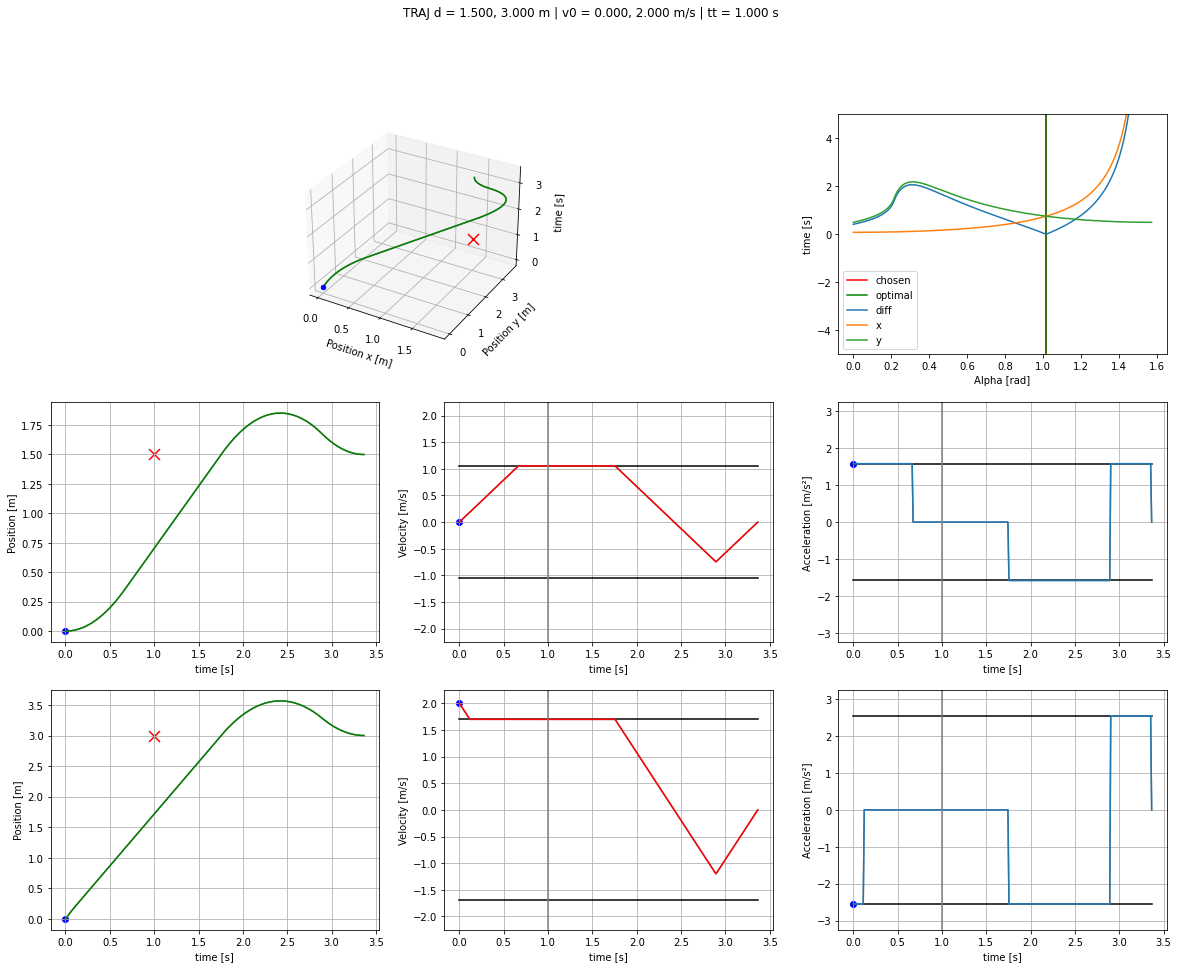

In [4]:


distances = [Vec2(1.5, 3)]
initial_velocities = [Vec2(0, 2)]
target_times = [1]

for d in sorted(set(distances)):
    for i_v in sorted(set(initial_velocities)):
        for tt in sorted(set(target_times)):
            fig = Plotter.plot(d, i_v, tt, max_vel, max_acc, PlotType.TRAJ)

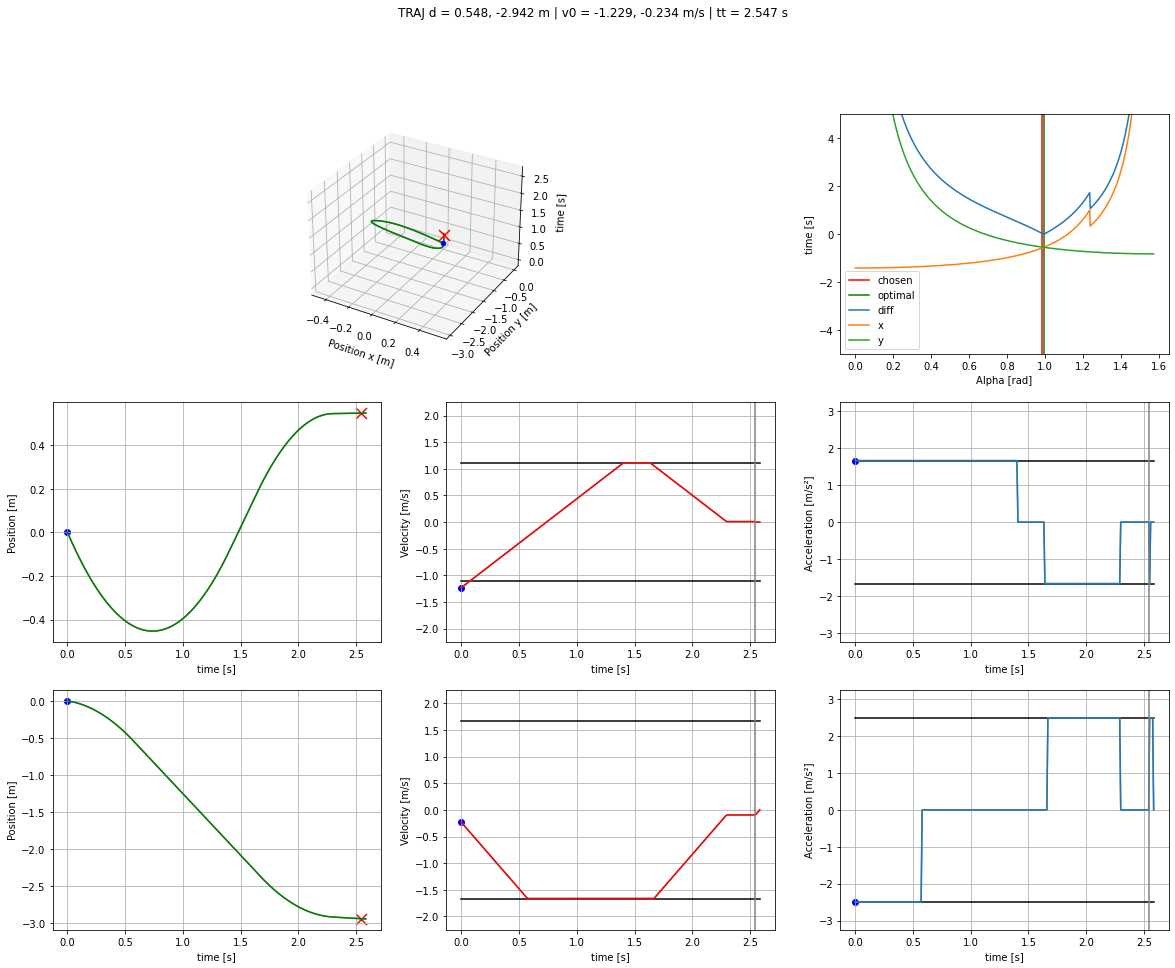

In [5]:
Plotter.plot(Vec2(0.548, -2.942), Vec2(-1.229, -0.234), 2.9495631519290217 - 0.4022954059789714, max_vel=max_vel,
             max_acc=max_acc, plot_type=PlotType.TRAJ)

In [6]:
test_values = [
    (0.0, 0.0, 0.0),
    (0.0, 1.0, 0.0),
    (0.0, 1.0, 1.0),
    (0.0, 1.0, 1.1),
    (0.5, 2.0, 0.5),
    (0.5, 2.0, 0.92),
    (1.0, 1.0, 0.5),
    (1.0, 1.0, 0.6),
    (1.0, 1.0, 1.0),
    (2.0, 2.0, 1.1),
    (2.0, 2.0, 2.0),
    (1.0, 0.0, 1.0),
]

for values in test_values:
    Plotter.plot(values[0], values[1], values[2], max_vel, max_acc, PlotType.NONE)

In [7]:
test_values = [
    ((-1.5, -3), (2, 0), 2.3),
    ((1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.2),
    ((-1, 0.5), (0, 0), 1),
    ((-1.5, -3), (0, 0), 2.6),
    ((-1.5, -3), (0, 0), 2.5),
    ((-1.5, -3), (0, 0), 2.4),
    ((-1.5, -3), (0, 0), 2.3),
]

for value in test_values:
    distance = Vec2(*value[0])
    initial_vel = Vec2(*value[1])
    target_time = value[2]
    Plotter.plot(distance, initial_vel, target_time, max_vel, max_acc, PlotType.NONE, show_fig=False)
    Plotter.plot(distance, initial_vel, target_time, max_vel, max_acc, PlotType.NONE)

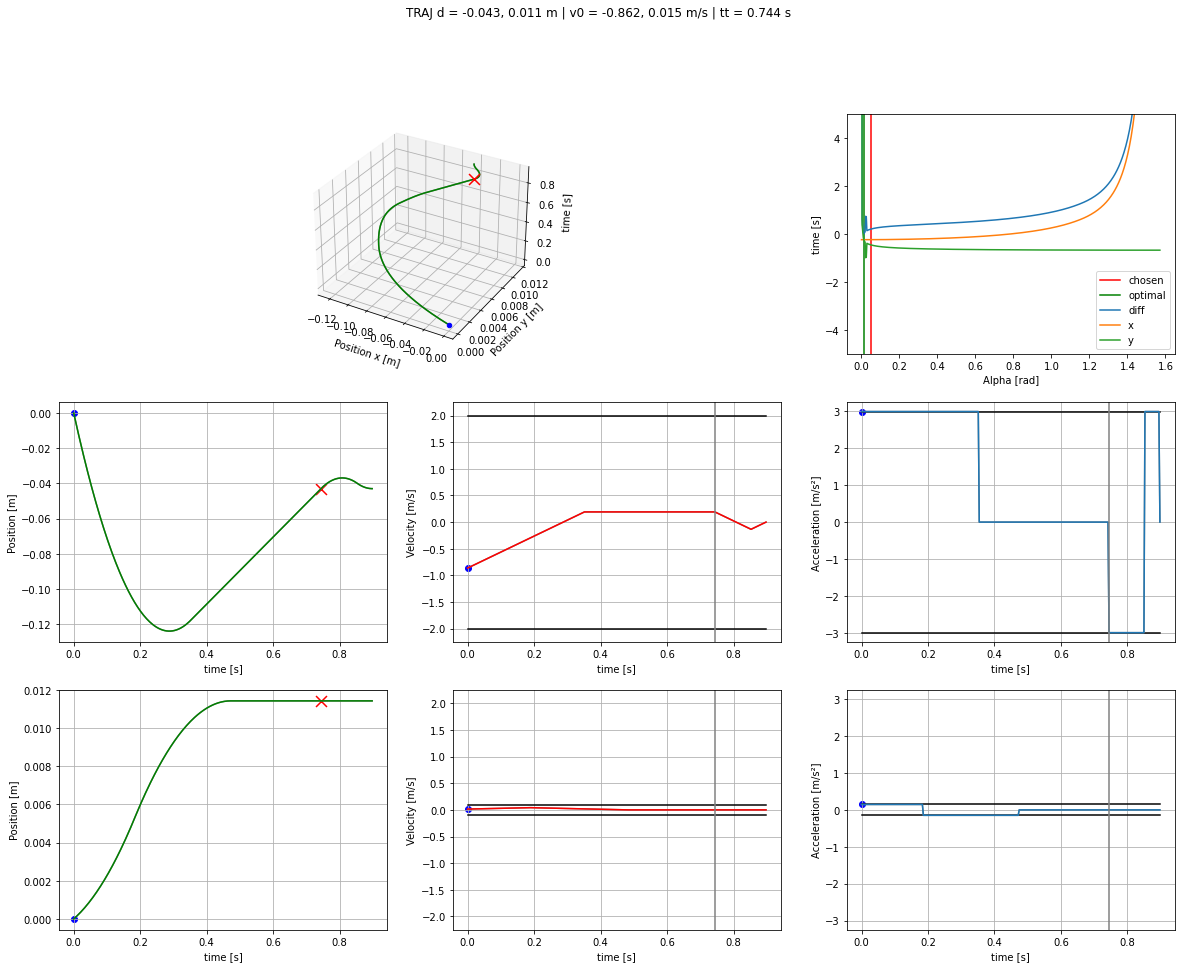

(-0.043, 0.011),(-0.862, 0.015),0.7438632020090901


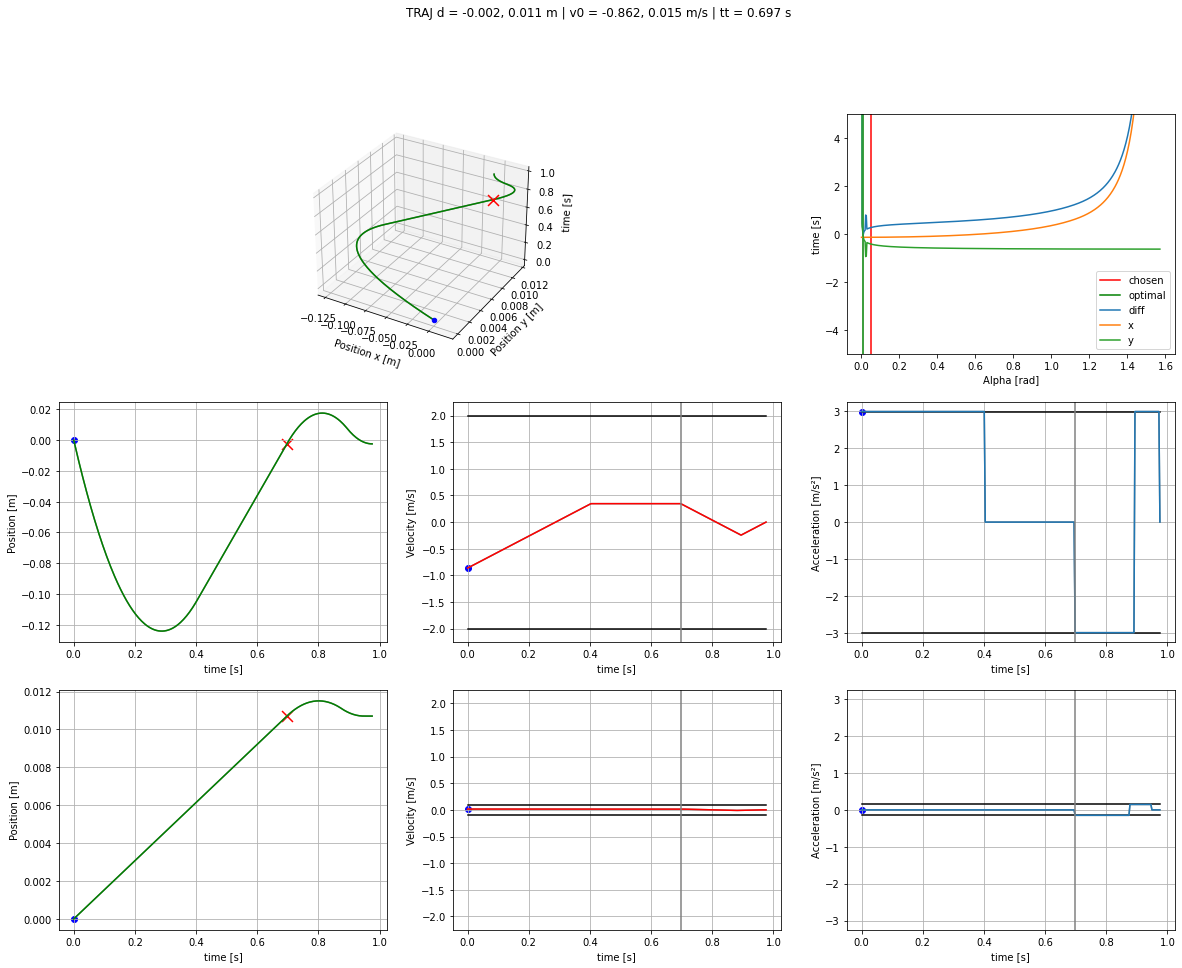

(-0.002, 0.011),(-0.862, 0.015),0.6967832525148439


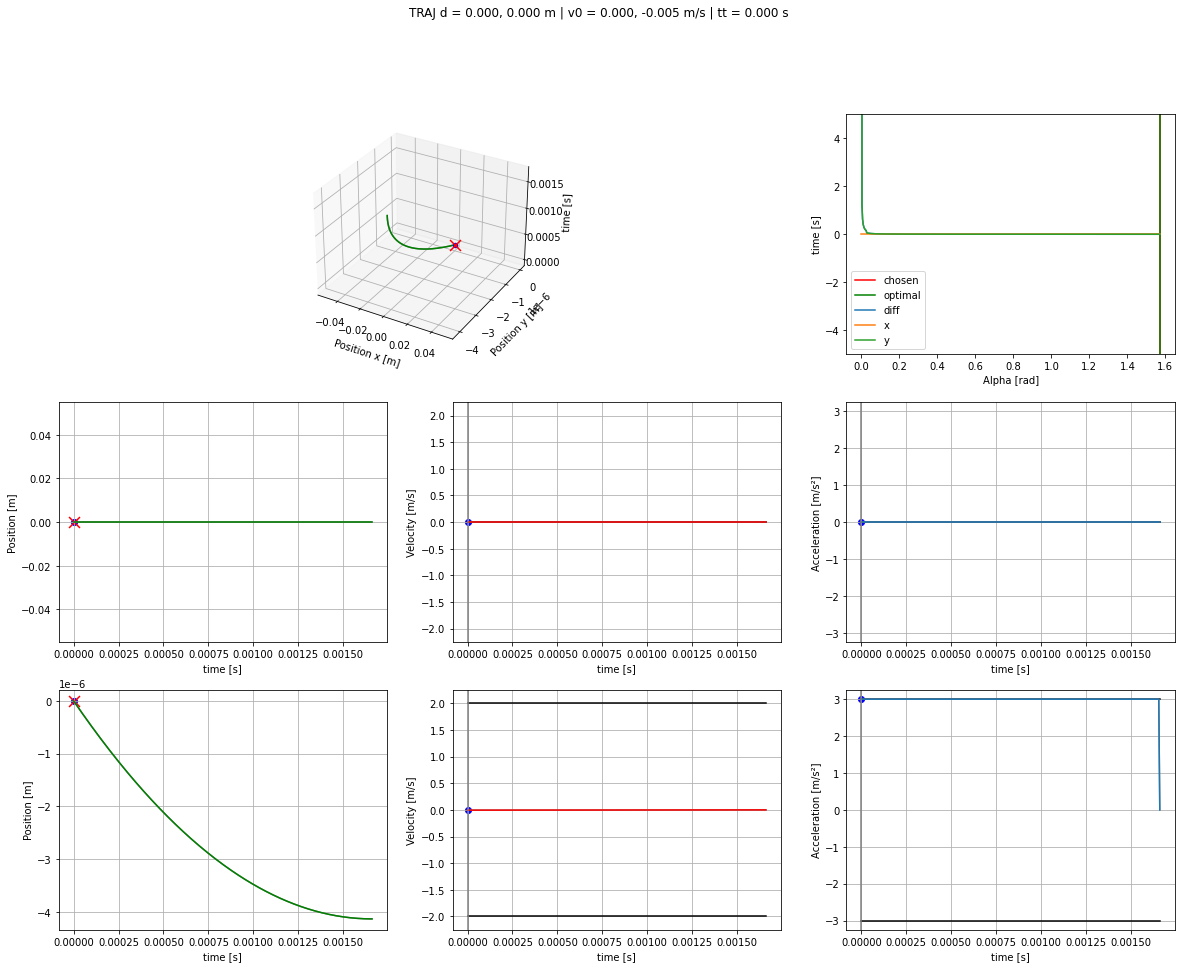

(0.000, 0.000),(0.000, -0.005),0.0
2.765423275920748 != 2.7426976887613614
-3.0105009623295116 != -2.9657452232976427


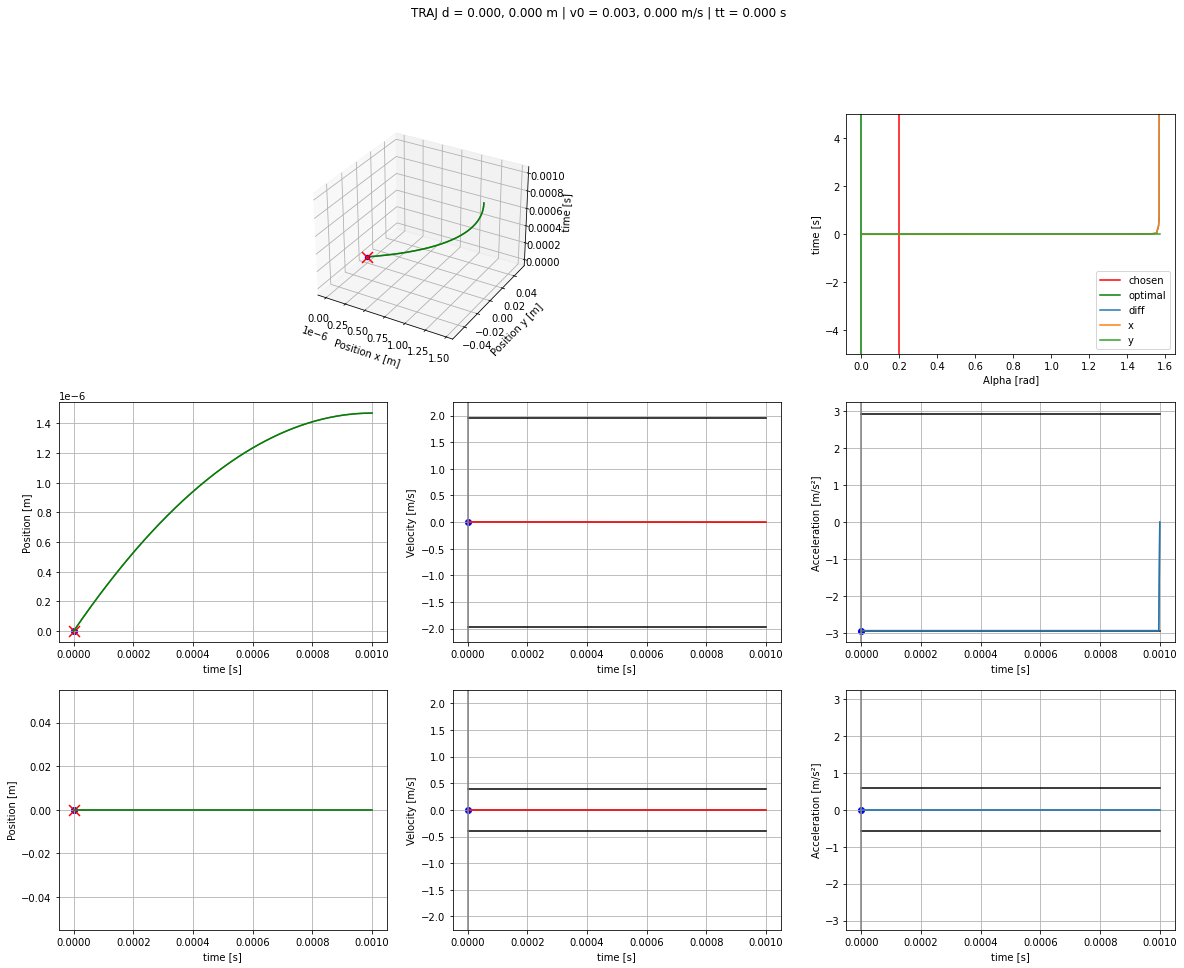

(0.000, 0.000),(0.003, 0.000),0.0


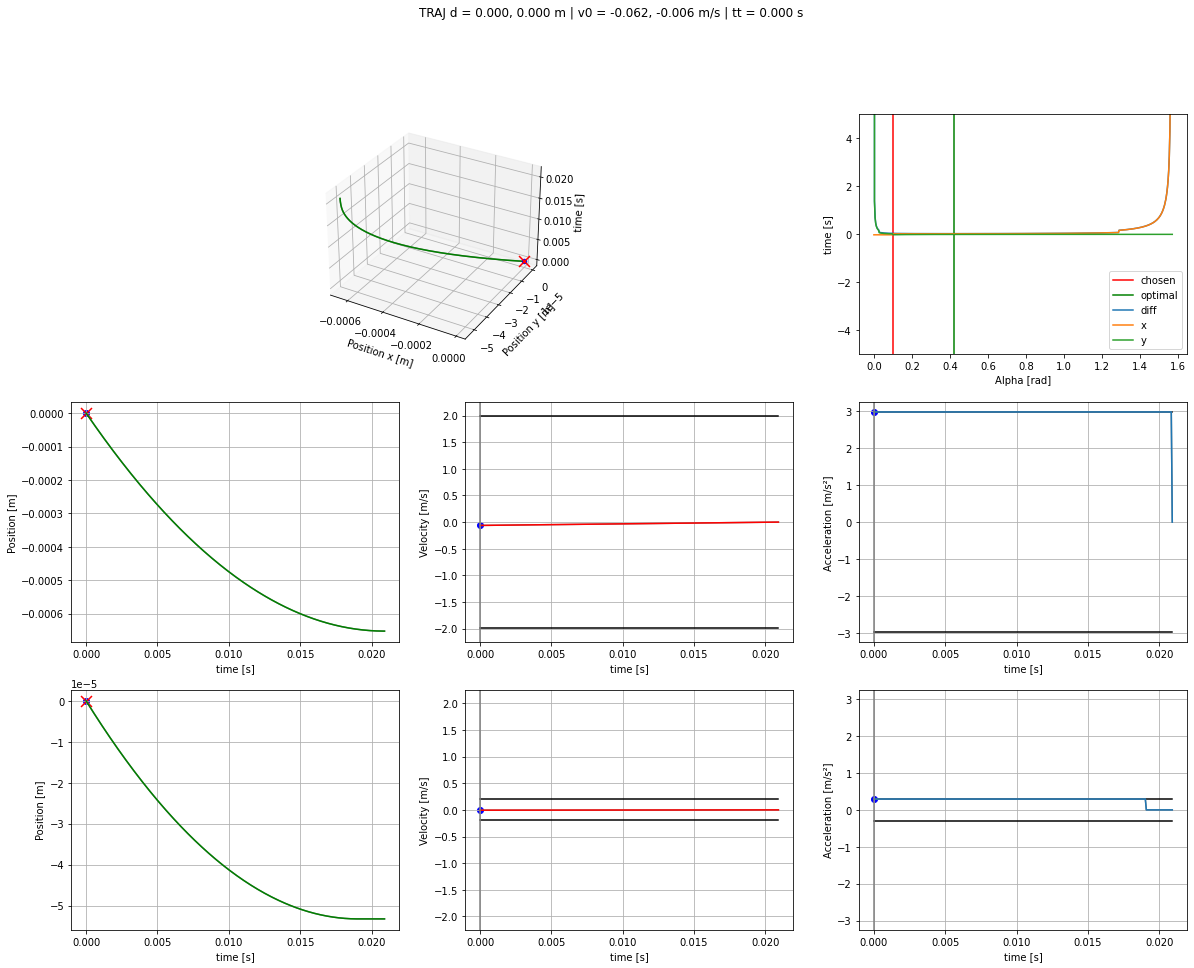

(0.000, 0.000),(-0.062, -0.006),0.0
1.8602489631904269 != 1.8495157702343796
0.29059358081688413 != 0.29561958835511515


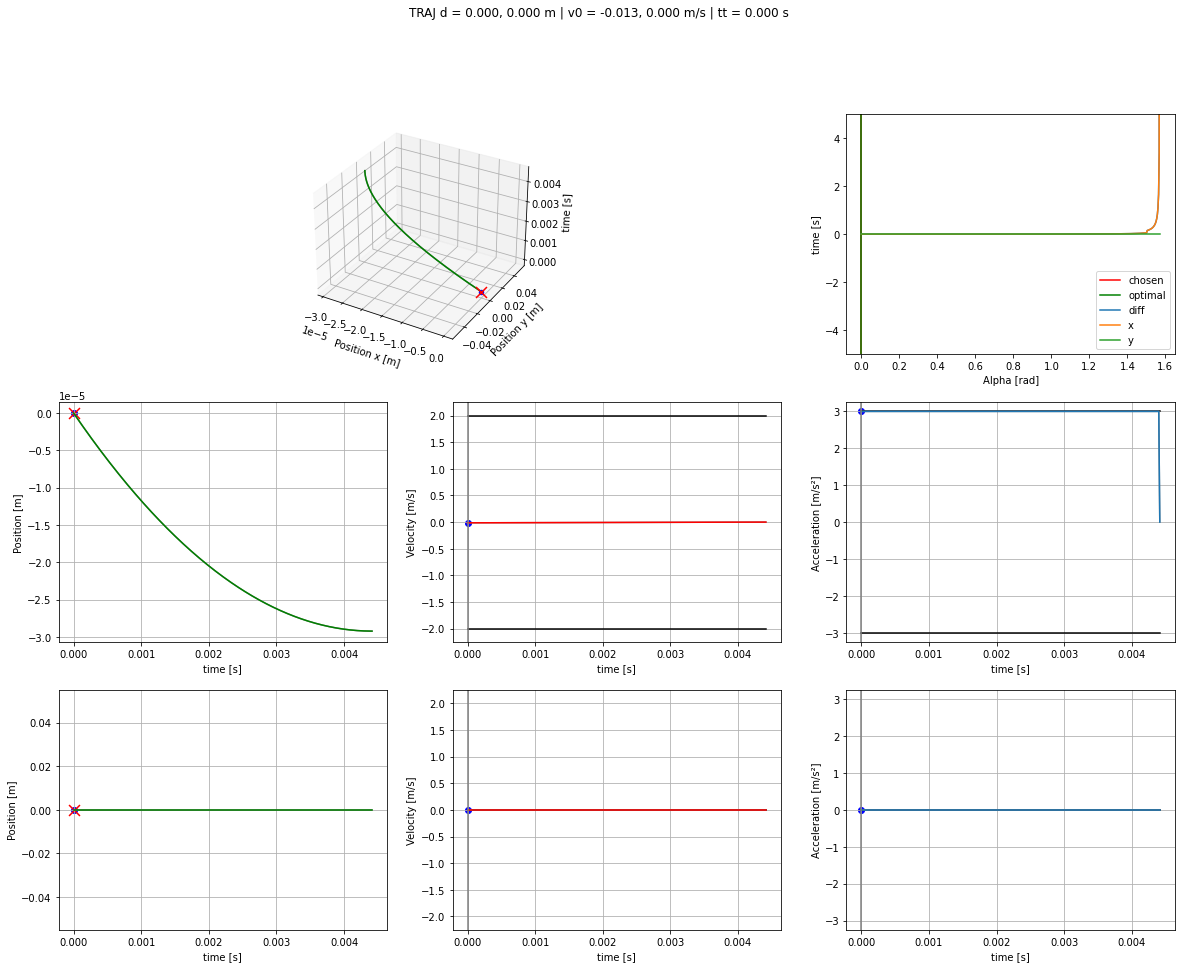

(0.000, 0.000),(-0.013, 0.000),0.0


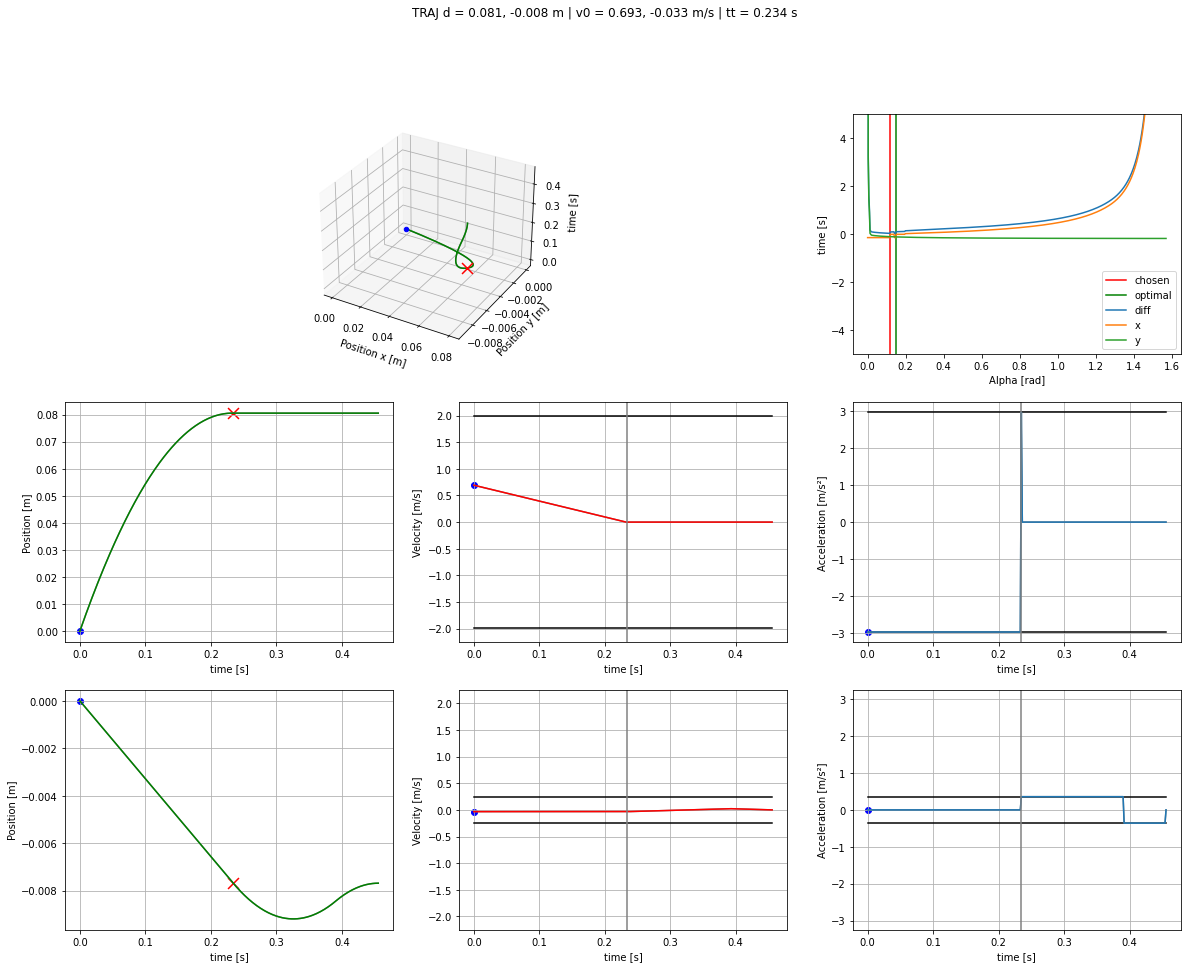

(0.081, -0.008),(0.693, -0.033),0.23414126480736486


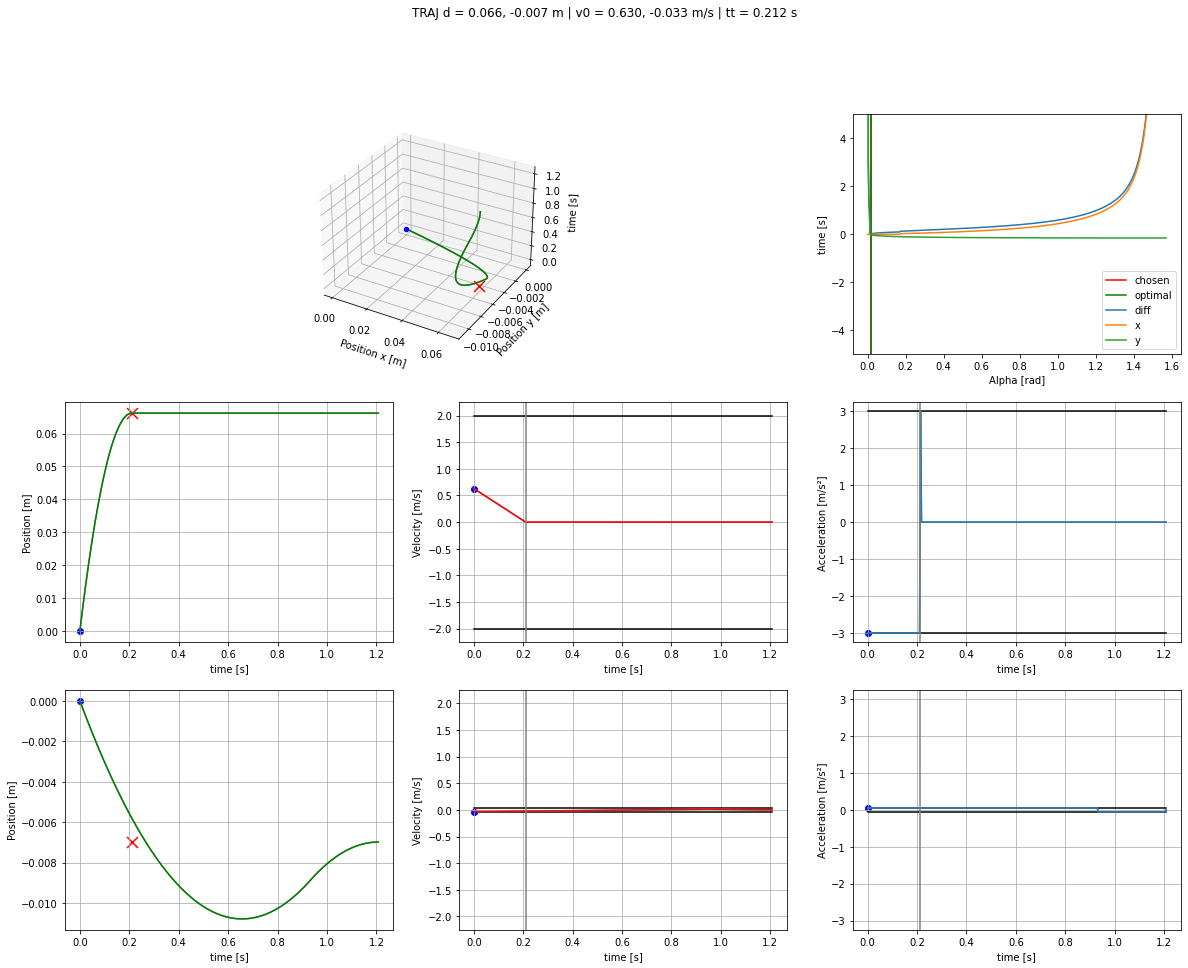

(0.066, -0.007),(0.630, -0.033),0.21246151806594216


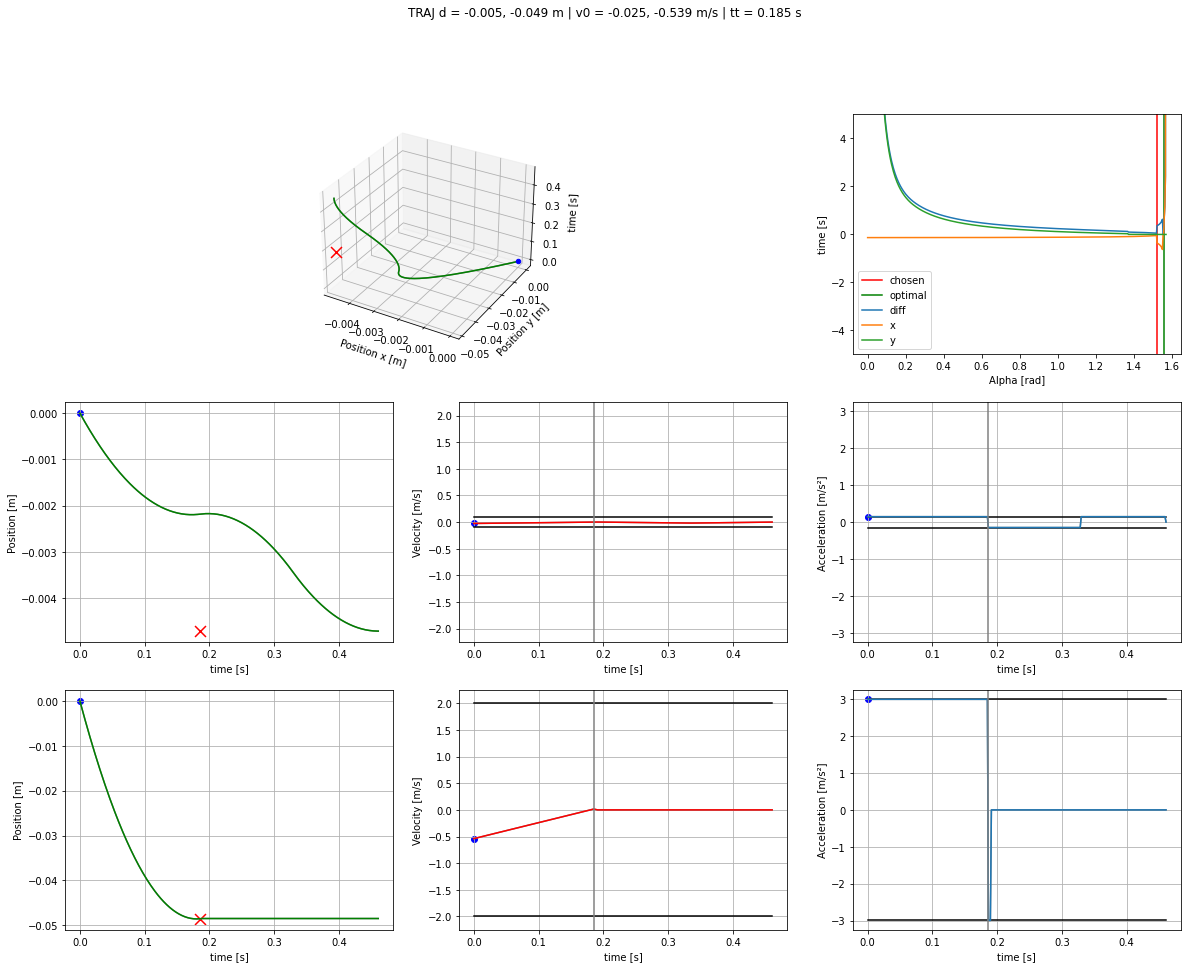

(-0.005, -0.049),(-0.025, -0.539),0.1854013097821532
Success!
Alphas Error: -0.10417926614407379 +- 0.2559813720327117


In [16]:
random.seed(1)
t_diffs = []
t_outlier = []
for _ in range(100):
    distance_x = random.uniform(-3, 3)
    distance_y = random.uniform(-3, 3)
    distance = Vec2(distance_x, distance_y)
    v0x = random.uniform(-max_vel, max_vel)
    v0y = random.uniform(-max_vel, max_vel)
    v0 = Vec2(v0x, v0y)
    target_time = random.uniform(0, 3)

    if math.isclose(target_time, 0.0, abs_tol=1e-4) or (
            math.isclose(distance_x, 0.0, abs_tol=1e-4) and math.isclose(distance_y, 0.0, abs_tol=1e-4)):
        continue

    try:
        sim_steps = Simulator(
            max_vel=max_vel,
            max_acc=max_acc,
            num_steps=40,
            step_size=5,
            distance=distance,
            initial_vel=v0,
            target_time=target_time).simulate()
        for step in sim_steps:
            if isinstance(step, SimStep2d):
                t_diff_optimal = BangBangTrajectory2D.diff_for_alpha(step.optimal_alpha, step.pos[0], step.pos[-1],
                                                                     step.vel[0], max_vel, max_acc,
                                                                     step.times[-1] - step.times[0])[0]
                t_diff_chosen = BangBangTrajectory2D.diff_for_alpha(step.alpha, step.pos[0], step.pos[-1],
                                                                    step.vel[0], max_vel, max_acc,
                                                                    step.times[-1] - step.times[0])[0]
                t_diffs.append(step.optimal_alpha - step.alpha)
                if math.fabs(max(t_diff_chosen - t_diff_optimal, 0.0)) > 5:
                    Plotter.plot(step.pos[-1] - step.current_pos(), step.vel[0], step.times[-1] - step.times[0],
                                 max_vel, max_acc, PlotType.TRAJ)
                    plt.show()
                    print("({}),({}),{}".format(step.pos[-1] - step.current_pos(), step.vel[0],
                                                step.times[-1] - step.times[0]))

        if isinstance(distance, Vec2):
            if not math.isclose(sim_steps[-1].current_pos().x, distance.x, abs_tol=0.01) or not math.isclose(
                    sim_steps[-1].current_pos().y, distance.y, abs_tol=0.01):
                print("{} != {}".format(sim_steps[-1].current_pos().x, distance.x))
                print("{} != {}".format(sim_steps[-1].current_pos().y, distance.y))
                # Plotter.plot(distance, v0, target_time, max_vel, max_acc, PlotType.TRAJ)
        else:
            assert math.isclose(sim_steps[-1].current_pos(), distance, abs_tol=1e-2,
                                rel_tol=1e-4), "{} != {}".format(sim_steps[-1].current_pos(), distance)
    except Exception as e:
        print("({}), ({}), {} failed".format(distance, v0, target_time))
        raise AssertionError(e)
print("Success!")
print("Alphas Error: {} +- {}".format(np.average(t_diffs), np.std(t_diffs)))

In [ ]:
sorted(t_diffs, key=lambda d: math.fabs(d))[-100:]